In [1]:
import os
import sys

from dotenv import load_dotenv

import librosa
import numpy as np
import pandas as pd

import librosa.display
from IPython.display import Audio, display
import matplotlib.pyplot as plt

import psycopg2
from psycopg2.extras import DictCursor

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from scripts.fetch_data import fetch_coughs_from_db

load_dotenv()

DB_CREDENTIALS = {
    'user': os.environ['PGUSER'],
    'password': os.environ['PGPASSWORD'],
    'host': os.environ['PGHOST'],
    'database': os.environ['PGDATABASE']
}

## Preprocessing

In [2]:
def get_row(data):
    return {
        "filename": data["filename"],
        "coughing": "coughing" in data["questions"]["symptoms"],
        "fatigue": "fatigue" in data["questions"]["symptoms"],
        "digestive_issues": "digestive_issues" in data["questions"]["symptoms"],
        "body_ache_chills": "body_ache_chills" in data["questions"]["symptoms"],
        "headache": "headache" in data["questions"]["symptoms"],
        "congestion": "congestion" in data["questions"]["symptoms"],
        "shortness_of_breath": "shortness_of_breath" in data["questions"]["symptoms"],
        "fever": "fever" in data["questions"]["symptoms"],
        "positive": data["questions"]["diagnosis"] == "tested_positive_present"
    }

In [3]:
BASE_PATH = "../data"

with psycopg2.connect(**DB_CREDENTIALS, cursor_factory=DictCursor) as conn:
    coughs = fetch_coughs_from_db(conn)

df = []
for c in coughs:
    f = f"{BASE_PATH}/{c['filename']}"

    # NOTE: hackily check if we have segments
    for i in range(1, 10):
        curr = f"{f.replace('.wav', '')}_cut00{i}.wav"
        if os.path.isfile(curr):
            c['filename'] = curr
            df.append(get_row(c))

df = pd.DataFrame(df)
df.head()

,filename,coughing,fatigue,digestive_issues,body_ache_chills,headache,congestion,shortness_of_breath,fever,positive
0,../data/coughs/be470bc1-959c-4653-a44e-b4b88cd...,False,False,False,False,False,False,False,False,False
1,../data/coughs/be470bc1-959c-4653-a44e-b4b88cd...,False,False,False,False,False,False,False,False,False
2,../data/coughs/be470bc1-959c-4653-a44e-b4b88cd...,False,False,False,False,False,False,False,False,False
3,../data/coughs/b38b64ff-871f-487c-b126-d6f6500...,False,False,False,False,False,False,False,False,False
4,../data/coughs/b38b64ff-871f-487c-b126-d6f6500...,False,False,False,False,False,False,False,False,False


In [4]:
print("Samples")
print(f"Positive: {len(df[df.positive==True])}")
print(f"Negative: {len(df[df.positive==False])}")

Samples
Positive: 61
Negative: 1190


Positive sample: ../data/coughs/9ae8463a-ed46-47ef-b7b7-97ae4016f0f2_cut002.wav


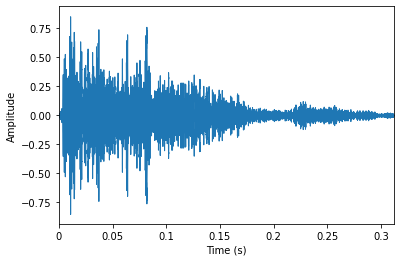

Negative sample: ../data/coughs/57dbe9b3-4283-4aec-a333-610e69de5438_cut002.wav


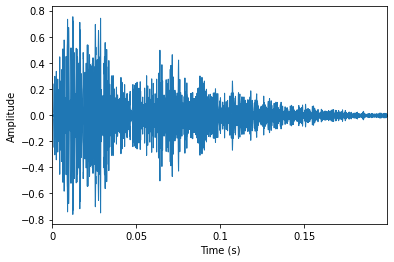

In [46]:
def plot_wave(x, sr):
    librosa.display.waveplot(x, sr=sr)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()    

pos = df[df.positive==True].iloc[1]
neg = df[df.positive==False].iloc[26]

print(f"Positive sample: {pos.filename}")
display(Audio(pos.filename))
yp, srp = librosa.load(f"{pos.filename}")
plot_wave(yp, srp)

print(f"Negative sample: {neg.filename}")
display(Audio(neg.filename))
yn, srn = librosa.load(f"{neg.filename}")
plot_wave(yn, srn)

Positive sample: ../data/coughs/9ae8463a-ed46-47ef-b7b7-97ae4016f0f2_cut002.wav


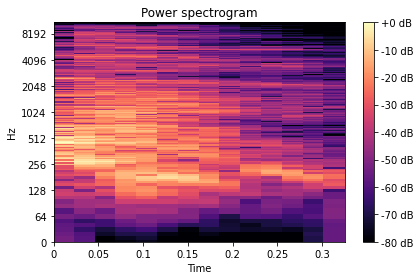

Negative sample: ../data/coughs/57dbe9b3-4283-4aec-a333-610e69de5438_cut002.wav


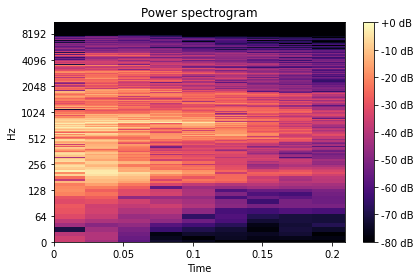

In [47]:
def plot_spec(x):
    x_stft = librosa.stft(x)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(x_stft), ref=np.max), y_axis='log', x_axis='time')
    plt.title('Power spectrogram')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

print(f"Positive sample: {pos.filename}")
plot_spec(yp)

print(f"Negative sample: {neg.filename}")
plot_spec(yn)

Positive sample: ../data/coughs/9ae8463a-ed46-47ef-b7b7-97ae4016f0f2_cut002.wav


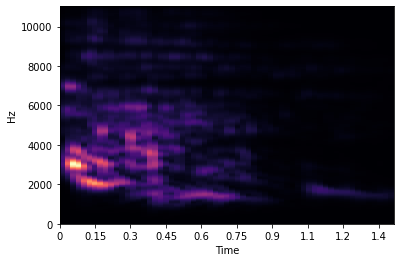

Negative sample: ../data/coughs/57dbe9b3-4283-4aec-a333-610e69de5438_cut002.wav


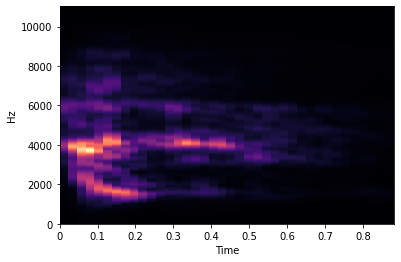

In [48]:
from src.preprocessing import GammatoneFilterbank

def plot_gf(x, sr):
    window_time = 0.01
    hop_time = window_time / 2
    num_filters = 512
    cutoff_low = 20

    gf = GammatoneFilterbank(sr,
                             window_time,
                             hop_time,
                             num_filters,
                             cutoff_low)

    gfs = gf.make_spectrogram(x)
    librosa.display.specshow(gfs, y_axis='linear', x_axis='time')
    plt.show()

print(f"Positive sample: {pos.filename}")
plot_gf(yp, srp)

print(f"Negative sample: {neg.filename}")
plot_gf(yn, srn)

## Classification

In [28]:
def vectorize(gf, f, sr=22050):
    y, sr = librosa.load(f, sr=sr)
    return gf.make_spectrogram(y)
    

sample_rate = 22050
window_time = 0.01
hop_time = window_time / 2
num_filters = 512
cutoff_low = 20

gf = GammatoneFilterbank(sample_rate,
                         window_time,
                         hop_time,
                         num_filters,
                         cutoff_low)

X, y = df.filename, df.positive
Xv, yv = [], []

for Xc, yc in zip(X, y):
    try:
        v = vectorize(gf, Xc)
        Xv.append(v)
        yv.append(int(yc))
    except ValueError as e:
        print(e)
        print(f"File {Xc} is too short...")


Input signal length=0 is too small to resample from 44100->22050
File ../data/coughs/be470bc1-959c-4653-a44e-b4b88cd1103e_cut003.wav is too short...
Input signal length=0 is too small to resample from 48000->22050
File ../data/coughs/dc384725-9ed6-4f4d-ab1d-b001fbeff0d8_cut004.wav is too short...
Input signal length=0 is too small to resample from 48000->22050
File ../data/coughs/e45bcca5-1230-4879-9db1-b55f95fcf0e0_cut002.wav is too short...
Input signal length=0 is too small to resample from 48000->22050
File ../data/coughs/e834db3d-36e6-4c6f-b3ce-b5e87adbea42_cut003.wav is too short...
Input signal length=0 is too small to resample from 48000->22050
File ../data/coughs/46109d84-a9e1-45a8-9975-6dab9c521d50_cut006.wav is too short...
Input signal length=0 is too small to resample from 48000->22050
File ../data/coughs/fed16d2a-7202-448f-86a2-c75ce5dbc640_cut003.wav is too short...
Input signal length=0 is too small to resample from 48000->22050
File ../data/coughs/3c113ec1-90ff-4e16-a4

Input signal length=0 is too small to resample from 48000->22050
File ../data/coughs/1f2f427f-ff0e-45ef-9c2c-1fd82c44dc20_cut004.wav is too short...
Input signal length=0 is too small to resample from 48000->22050
File ../data/coughs/7e94679f-1e04-4bb3-80a8-4c7431c9f556_cut002.wav is too short...
Input signal length=0 is too small to resample from 48000->22050
File ../data/coughs/e5cfe1f9-ff25-44da-9160-a058447d9002_cut002.wav is too short...
Input signal length=0 is too small to resample from 48000->22050
File ../data/coughs/a5c7ce31-e668-4650-b159-8127c0823d08_cut003.wav is too short...
Input signal length=0 is too small to resample from 48000->22050
File ../data/coughs/68c93768-4a23-4cfa-b15b-f886c9a14595_cut004.wav is too short...
Input signal length=0 is too small to resample from 44100->22050
File ../data/coughs/230068cf-e943-4abd-8e3e-8913e6ac2f60_cut003.wav is too short...
Input signal length=0 is too small to resample from 48000->22050
File ../data/coughs/f921485a-2120-4a07-b7

Input signal length=0 is too small to resample from 48000->22050
File ../data/coughs/29690def-c94e-46de-9c03-e95389f64092_cut002.wav is too short...
Input signal length=0 is too small to resample from 44100->22050
File ../data/coughs/384d60b8-8d18-4f74-8cf5-fbe9a6d825b7_cut004.wav is too short...
Input signal length=0 is too small to resample from 48000->22050
File ../data/coughs/9c85cf6a-985a-4c68-a32d-9848c264b8ba_cut008.wav is too short...
Input signal length=0 is too small to resample from 48000->22050
File ../data/coughs/3dbe2734-0b51-4823-b45f-e541deb2f30e_cut009.wav is too short...
Input signal length=0 is too small to resample from 48000->22050
File ../data/coughs/9821dbf6-64de-456a-87f8-b779e5a47b39_cut003.wav is too short...
Input signal length=0 is too small to resample from 48000->22050
File ../data/coughs/d46896cf-cee9-4e8b-b483-c5133a7b2766_cut003.wav is too short...
Input signal length=0 is too small to resample from 48000->22050
File ../data/coughs/5825c122-f072-4ed9-83

Input signal length=0 is too small to resample from 48000->22050
File ../data/coughs/42257f5b-9ecd-423b-8b5b-1209de5cada1_cut004.wav is too short...
Input signal length=0 is too small to resample from 48000->22050
File ../data/coughs/4689ff57-5e16-4b84-8951-f828b2ab4f1e_cut004.wav is too short...
Input signal length=0 is too small to resample from 48000->22050
File ../data/coughs/18ad5fca-168e-4762-83da-286f377b2d08_cut004.wav is too short...
Input signal length=0 is too small to resample from 44100->22050
File ../data/coughs/83eb6bec-d84e-4c5b-9007-b30485e9cd42_cut005.wav is too short...
Input signal length=0 is too small to resample from 48000->22050
File ../data/coughs/54fa2928-27b4-40e7-903c-546d9c3cd411_cut005.wav is too short...
Input signal length=0 is too small to resample from 48000->22050
File ../data/coughs/d62be97b-9f86-451c-b75a-4e33b1426247_cut001.wav is too short...
Input signal length=0 is too small to resample from 48000->22050
File ../data/coughs/3787eeff-86be-4cd0-83

Input signal length=0 is too small to resample from 44100->22050
File ../data/coughs/93437804-779b-4143-aad8-8b2ce5f30074_cut002.wav is too short...
Input signal length=0 is too small to resample from 48000->22050
File ../data/coughs/cb9ef3b3-1da9-41d1-a979-1772e9018e72_cut005.wav is too short...
Input signal length=0 is too small to resample from 48000->22050
File ../data/coughs/51478383-d59e-4499-ad4c-3cfac5aef1e1_cut006.wav is too short...
Input signal length=0 is too small to resample from 48000->22050
File ../data/coughs/dcc0b13e-4cf4-4eec-bf52-a6df867b75c0_cut005.wav is too short...
Input signal length=0 is too small to resample from 48000->22050
File ../data/coughs/45714334-d835-45ea-9935-aa0056383ec3_cut003.wav is too short...
Input signal length=0 is too small to resample from 48000->22050
File ../data/coughs/72854247-70f9-41cd-bd31-dc32904ddd5e_cut003.wav is too short...
Input signal length=0 is too small to resample from 44100->22050
File ../data/coughs/3832d264-c01e-4aea-bc